In [1]:
# This is a demo on using GMTSAR to process InSAR data. Materials are taken from the universal 
# p2p_processing.csh script.
# 
# Created on 05/11/2022 by Xiaohua Xu (xiaohua.xu@austin.utexas.edu)
#
# Modification History:
# 05/12/2022: Putting things together. Xiaohua Xu
#
# The dataset used in this script could be downloaded from http://topex.ucsd.edu/gmtsar/tar/RS2_SLC_Hawaii.tar.gz

In [2]:
# Start with importing the needed libs
import os
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np
# Cleaning
! cleanup.csh all


clean up all
rm: No match.



In [3]:
# Start by checking the prepared data and DEM. The data are renamed to $SAT_$date.$file_type. 
! ls 
print ("in raw")
! ls raw
print ("in topo")
! ls topo

gmtsar_rs2_demo.ipynb raw                   topo
in raw
RS2_20110515.tif RS2_20110819.tif junk             test2.grd
RS2_20110515.xml RS2_20110819.xml test.grd
in topo
dem.grd


In [4]:
# Start processing the data, go to the raw directory and convert the data into GMTSAR format
# which is .PRM for parameters, .LED for orbit records, and level 1.1 .SLC file (or .raw for level 1.0).

# Set some variable
master = "RS220110515"
aligned = "RS220110819"

# Go to the raw directory
os.chdir("raw")

# Decode the data. For data from other platforms, this step will use other c-code modules, 
# such as, ALOS_pre_process, make_slc_s1a, etc.
! make_slc_rs2 {master + ".xml"} {master + ".tif"} {master}
! make_slc_rs2 {aligned + ".xml"} {aligned + ".tif"} {aligned}
os.chdir("..")

2633 1620 
1 
PRM set for Image File...
5 Lines Written for Orbit...
Writing SLC..Image Size: 3416 X 5749...
Fliping leftside right for Descending Image...
2633 1620 
1 
PRM set for Image File...
5 Lines Written for Orbit...
Writing SLC..Image Size: 3416 X 5746...
Fliping leftside right for Descending Image...


 range decimation is: 2


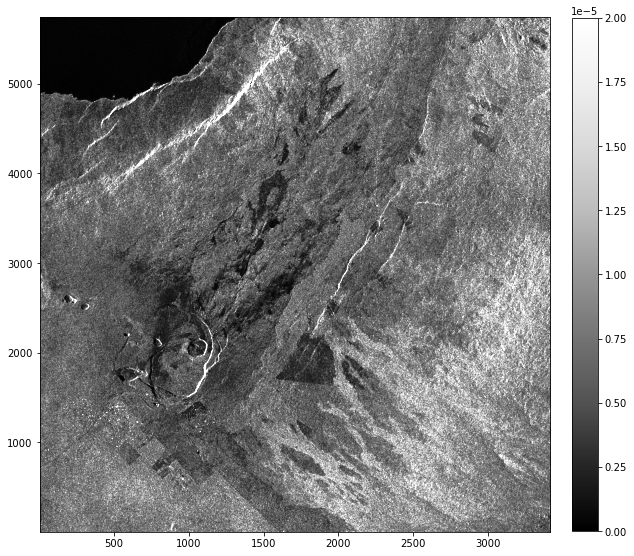

In [7]:
# None-Necessary Plotting part
# Check on the radar amplitude data for the master image
# Do note that this is plotted upside down, but the data following this conversion 
# is also upside down, so it is in the right coordinates
os.chdir("raw")
! slc2amp.csh {master + ".PRM"} 2 test.grd
os.chdir("..")

nc = NetCDFFile('raw/test.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
a = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=0.6,vmin = 0, vmax = 2e-5)
plt.rcParams["figure.figsize"] = [10,10]
bar1 = plt.colorbar(a,fraction=0.046, pad=0.04)

 range decimation is: 2


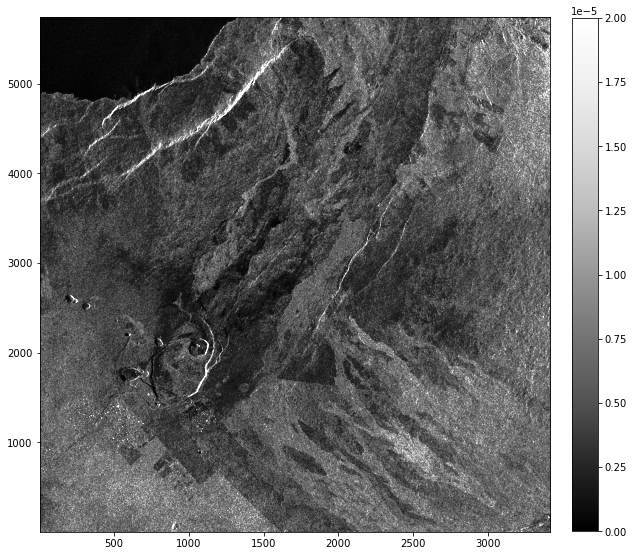

In [6]:
# None-Necessary Plotting part
# Check on the radar amplitude data for the aligned image
os.chdir("raw")
! slc2amp.csh {aligned + ".PRM"} 2 test2.grd
os.chdir("..")

nc = NetCDFFile('raw/test2.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=0.6,vmin = 0, vmax = 2e-5)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

In [7]:
# Extend the orbit (for RS2 only) and calculate satellite velocity parameters. 
# The extension of orbit is done by a factor of 3. This is usually not required when 
# you have precise orbit product for other satellite data
os.chdir("raw")
! mv {master + ".LED"} {"save-" + master + ".LED"}
! extend_orbit {"save-" + master + ".LED"} {master + ".LED"} 3
! mv {aligned + ".LED"} {"save-" + aligned + ".LED"}
! extend_orbit {"save-" + aligned + ".LED"} {aligned + ".LED"} 3

! cp {master + ".PRM"} {master + ".PRM0"} 
! calc_dop_orb {master + ".PRM0"} junk 0 0
! cat junk >> {master + ".PRM"}
! cp {aligned + ".PRM"} {aligned + ".PRM0"} 
! calc_dop_orb {aligned + ".PRM0"} junk 0 0
! cat junk >> {aligned + ".PRM"}
os.chdir("..")

Successfully opened RS2_20110515.PRM0 
Successfully opened RS2_20110819.PRM0 


In [8]:
# Create a directory called SLC, copy or link files over and perform co-registration. 
! mkdir SLC
os.chdir("SLC")
! rm -rf * 
! cp {"../raw/" + master + ".PRM"} .
! ln -s {"../raw/" + master + ".LED"} .
! ln -s {"../raw/" + master + ".SLC"} .
! cp {"../raw/" + aligned + ".PRM"} .
! ln -s {"../raw/" + aligned + ".LED"} .
! ln -s {"../raw/" + aligned + ".SLC"} .

# Coregistration
! cp {aligned + ".PRM"} {aligned + ".PRM0"} 
#   calculate initial baseline parameters and offset so the following xcorr knows where
#   to perform the co-registration
! SAT_baseline {master + ".PRM"} {aligned + ".PRM"} >> {aligned + ".PRM"}
#   run xcorr (cross correlation)
! xcorr {master + ".PRM"} {aligned + ".PRM"} -xsearch 128 -ysearch 128 -nx 20 -ny 20
#   fit an affine transformation (2 by 2 parameter for RS2), and save them to the alinged PRM file
! fitoffset.csh 2 2 freq_xcorr.dat 18 >> {aligned + ".PRM"}
#   resample the aligned images to match the master image, using a sync interpolator (mode 4)
! resamp {master + ".PRM"} {aligned + ".PRM"} {aligned + ".PRMresamp"} {aligned + ".SLCresamp"} 4
#   some cleaning
! rm {aligned + ".SLC"}
! mv {aligned + ".SLCresamp"} {aligned + ".SLC"}
! cp {aligned + ".PRMresamp"} {aligned + ".PRM"}

os.chdir("..")

rm: No match.
......master LED file RS2_20110515.LED 
.........aligned LED file RS2_20110819.LED 
 setting xsearch to 128
 setting nx_corr to 256
 setting ysearch to 128
 setting ny_corr to 256
 setting nx to 20
 setting ny to 20
 3416 5748 3416 5744 8 2 0.000000
 locations  n 400 nx 3416 nyl 20 nxl 20 x_inc 115 y_inc 237
 elapsed time: 44.476841 


In [8]:
# Compute the Geocoding look up table, convert DEM into elevation in radar coordinates.
# This file will be used later to remove topographic phase.
os.chdir("topo")
! cp ../SLC/{master + ".PRM"} master.PRM
! ln -s ../raw/{master + ".LED"} .
# Run the computation, here we'll use a fast interpolation method rather than the default gmt surface
! dem2topo_ra.csh master.PRM dem.grd 1
os.chdir("..")

cp: ../SLC/RS2_20110515.PRM: No such file or directory
grep: master.PRM: No such file or directory
grep: master.PRM: No such file or directory
grep: master.PRM: No such file or directory
grep: master.PRM: No such file or directory
grep: No match.
Working over 0//0/0 ... 
grep: master.PRM: No such file or directory
range sampling rate out of bounds


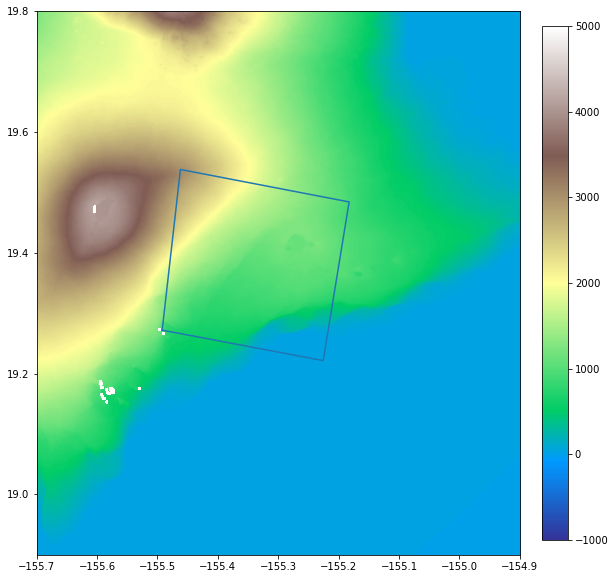

In [10]:
# None-Necessary Plotting part
# Check on the dem plot
nc = NetCDFFile('topo/dem.grd')
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='terrain',aspect=1,vmin = -1000, vmax = 5000)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)
# plot the foot print of this pair
coord = [[-155.492023255,  19.2719230486], 
[-155.225471042,  19.221533534], 
[-155.182503719,  19.4842601626], 
[-155.461852893,  19.5379469499],
[-155.492023255,  19.2719230486]]
xs, ys = zip(*coord)
plt.plot(xs,ys)

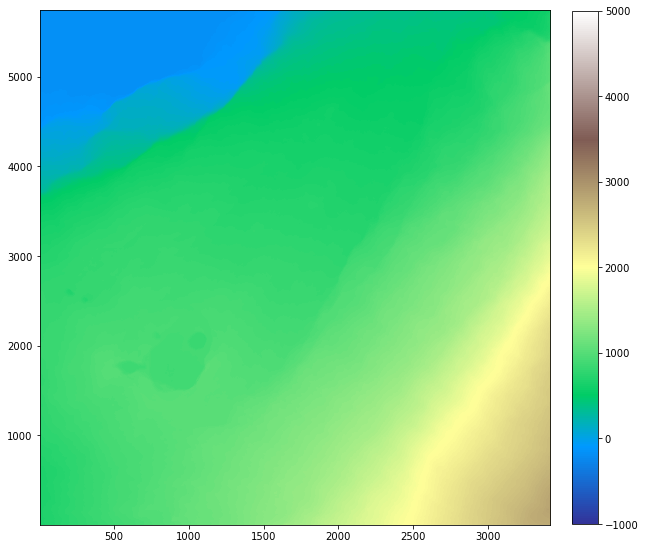

In [11]:
# None-Necessary Plotting part
# Check on the topo_ra plot
nc = NetCDFFile('topo/topo_ra.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='terrain',aspect=0.6,vmin = -1000, vmax = 5000)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

In [12]:
# Create a directory called intf, copy or link files over, and 
# perform interferometry + filtering
! mkdir intf
os.chdir("intf")

# Set some variables, reference and repeat
ref = "RS2_20110515"
rep = "RS2_20110819"
#    get the following from the integer part of SC_clock_start from the PRM files
ref_id = "2011134"
rep_id = "2011230"

# Create the interferogram directory, copy or link files over

intf_dir = {ref_id + "_" + rep_id}
! mkdir {intf_dir}
os.chdir(str(ref_id + "_" + rep_id))
! ln -s {"../../SLC/" + ref + ".LED"} .
! ln -s {"../../SLC/" + rep + ".LED"} .
! ln -s {"../../SLC/" + ref + ".SLC"} .
! ln -s {"../../SLC/" + rep + ".SLC"} .
! cp {"../../SLC/" + ref + ".PRM"} .
! cp {"../../SLC/" + rep + ".PRM"} .
! ln -s ../../topo/topo_ra.grd .

# Perform interferometry
! intf.csh {ref + ".PRM"} {rep + ".PRM"} -topo topo_ra.grd

# Filter the interferogram using a 200-m gaussian filter, with decimating 2 in range and 4 in azimuth
! filter.csh {ref + ".PRM"} {rep + ".PRM"} 200 1 2 4

os.chdir("../..")

......master LED file RS2_20110515.LED 
.........aligned LED file RS2_20110819.LED 
......master LED file RS2_20110515.LED 
.........aligned LED file RS2_20110515.LED 
intf.csh
running phasediff...
reading topo topo_ra.grd
 xdim 3416, ydim 5748 
filter.csh
setting range_dec = 2, azimuth_dec = 4
gauss_200 1 1 (4 2)
making amplitudes...
filtering interferogram...
making amplitude...
making correlation...
making phase...
filtering phase...


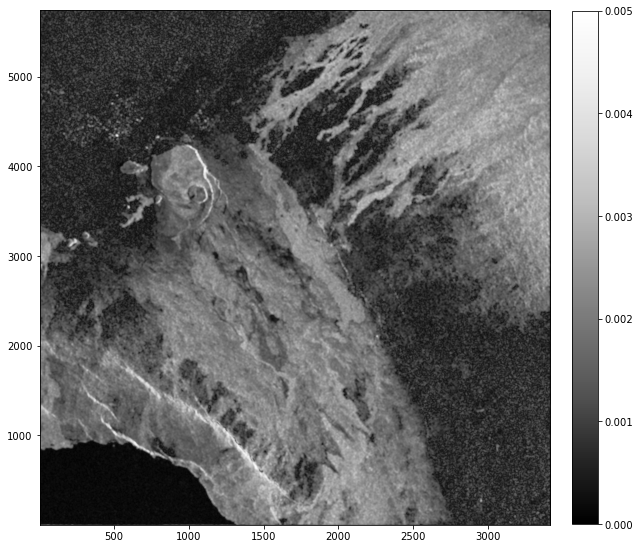

In [13]:
# None-Necessary Plotting part
# Check on the amplitude image in radar coordinates, do note this is a 
# fake amplitude for display purpose, not real amplitude 
nc = NetCDFFile('intf/2011134_2011230/display_amp.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=0.6,vmin = 0, vmax = 0.005)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

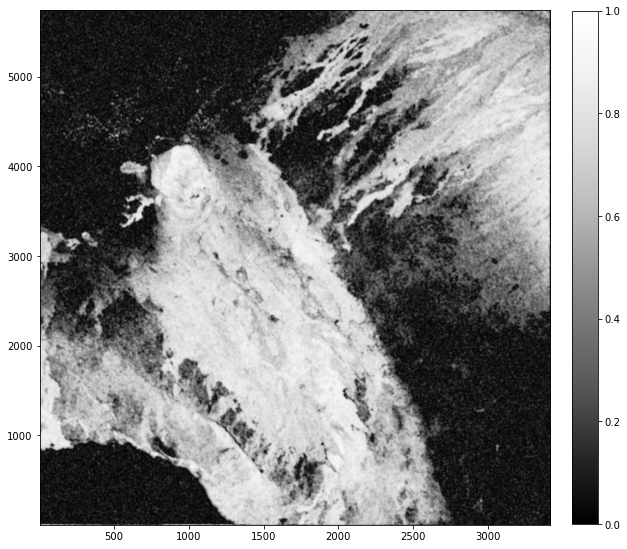

In [14]:
# None-Necessary Plotting part
# Check on the coherence in radar coordinates
nc = NetCDFFile('intf/2011134_2011230/corr.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=0.6,vmin = 0, vmax = 1)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

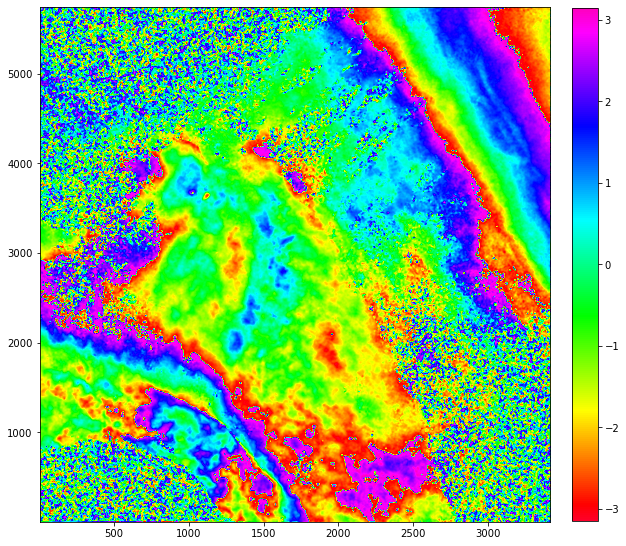

In [15]:
# None-Necessary Plotting part
# Check on the phase in radar coordinates
nc = NetCDFFile('intf/2011134_2011230/phase.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='gist_rainbow',aspect=0.6,vmin = -3.15, vmax = 3.15)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

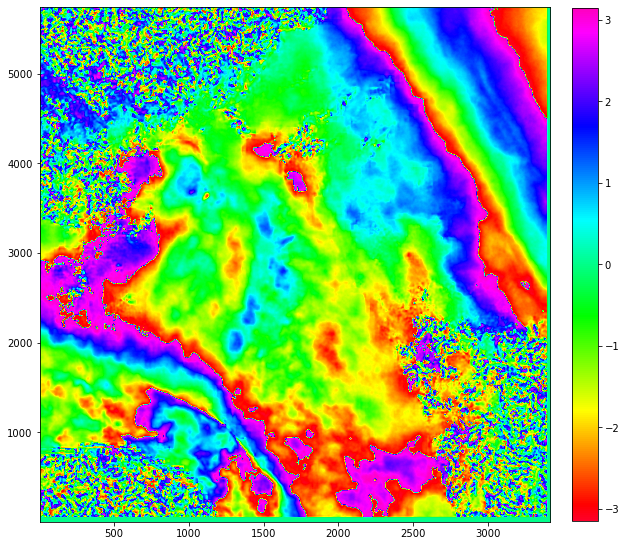

In [16]:
# None-Necessary Plotting part
# Check on the phasefilt in radar coordinates, this is the radar phase after Goldstein filter (spectral)
nc = NetCDFFile('intf/2011134_2011230/phasefilt.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='gist_rainbow',aspect=0.6,vmin = -3.15, vmax = 3.15)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

In [17]:
# Unwrap the interferogram with a 0.1 coherence threshold
# Create a landmask to mask the wet region, here make the region a little 
# bit larger than the data
os.chdir("topo")
! landmask.csh {"-20/" + str(int(np.max(x)+20)) + "/-20/" + str(int(np.max(y)+20))}
os.chdir("..")

# Unwrap the interferogram
os.chdir("intf/" + str(ref_id + "_" + rep_id))
! ln -s ../../topo/landmask_ra.grd .
! snaphu.csh 0.1 0 > log_unwrap
os.chdir("../..")


MAKE LANDMASK -- START
REQUIRE FULL RESOLUTION COASTLINE FROM GMT

grdlandmask [INFORMATION]: Selected ice front line as Antarctica coastline
grdlandmask [INFORMATION]: GSHHG version 2.3.7
grdlandmask [INFORMATION]: Derived from World Vector Shoreline, CIA WDB-II, and Atlas of the Cryosphere
grdlandmask [INFORMATION]: Processed by Paul Wessel and Walter H. F. Smith, 1994-2017
grdlandmask [INFORMATION]: Nodes in water will be set to NaN
grdlandmask [INFORMATION]: Nodes on land will be set to 1
grdlandmask [INFORMATION]: Apply linear scale to avoid wrap-around: -Jx100id; this temporarily changes the domain
grdlandmask [INFORMATION]: Writing grid to file landmask.grd
grdlandmask [INFORMATION]: Level 0 set for 3433280 nodes
grdlandmask [INFORMATION]: Level 1 set for 5904041 nodes
surface [INFORMATION]: Provides 3, expects 3-column binary data
surface [INFORMATION]: Cartesian input grid
surface [INFORMATION]: Cartesian input grid
surface [INFORMATION]: Grid domain: W: -155.749999994 E: -15

surface [INFORMATION]: Fill in expanded grid by bilinear interpolation [stride = 4]
surface [INFORMATION]:    4	I	     107	2.06081929728e-05	2.08114830362e-05	      6226
surface [INFORMATION]: Determine nearest point and set Briggs coefficients [stride = 4]
surface [INFORMATION]:    4	D	    2000	0.00140364949404	2.08114830362e-05	      8226
surface [INFORMATION]: Recompute data index for next iteration [stride = 2]
surface [INFORMATION]: Expand grid by factor of 2 when going from stride = 4 to 2
surface [INFORMATION]: Fill in expanded grid by bilinear interpolation [stride = 2]
surface [INFORMATION]:    2	I	      23	3.2905090139e-05	4.16229660724e-05	      8249
surface [INFORMATION]: Determine nearest point and set Briggs coefficients [stride = 2]
surface [INFORMATION]:    2	D	    1000	0.000305371740335	4.16229660724e-05	      9249
surface [INFORMATION]: Recompute data index for next iteration [stride = 1]
surface [INFORMATION]: Expand grid by factor of 2 when going from stride = 2 to 

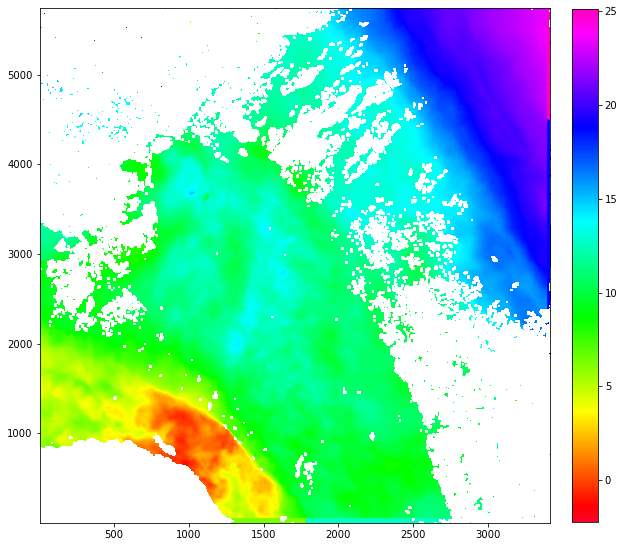

In [18]:
# None-Necessary Plotting part
# Check on the unwrapped interferogram
nc = NetCDFFile('intf/2011134_2011230/unwrap.grd')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
z = nc.variables['z'][:]
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='gist_rainbow',aspect=0.6,vmin = np.min(z), vmax = np.max(z))
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)

In [19]:
# Make projection to Geo-coordinates
os.chdir("intf/" + str(ref_id + "_" + rep_id))
# Link the projection matrix here
! ln -s ../../topo/trans.dat .
# Make projection with masking based on coherence (0.1)
! geocode.csh 0.1
os.chdir("../..")

grdmath [INFORMATION]: Perform reverse Polish notation calculations on grids
grdmath [INFORMATION]: netCDF grid corr.grd has no default CPT.
grdmath [INFORMATION]: Cartesian input grid
grdmath [INFORMATION]: corr.grd grdmath [INFORMATION]: netCDF grid corr.grd has no default CPT.
grdmath [INFORMATION]: Cartesian input grid
grdmath [INFORMATION]: Reading grid from file corr.grd
grdmath [INFORMATION]: Cartesian input grid
grdmath [INFORMATION]: gmt_grd_BC_set: Set boundary condition for all edges: natural
grdmath [INFORMATION]: gmt_grd_BC_set: Set boundary condition for left   edge: natural
grdmath [INFORMATION]: gmt_grd_BC_set: Set boundary condition for right  edge: natural
grdmath [INFORMATION]: gmt_grd_BC_set: Set boundary condition for bottom edge: natural
grdmath [INFORMATION]: gmt_grd_BC_set: Set boundary condition for top    edge: natural
0.1 GE 0 NAN mask.grd grdmath [INFORMATION]: netCDF grid mask.grd has no default CPT.
grdmath [INFORMATION]: Cartesian input grid
grdmath [INFO

blockmedian [INFORMATION]: Writing Data Table to Standard Output stream
blockmedian [INFORMATION]: Calculating block medians
blockmedian [INFORMATION]: N read: 2454396 N used: 2454396 outside_area: 0 N cells filled: 430561
proj_ra2ll.csh
Sampling in geocoordinates with 50 meter pixels ...
blockmedian [INFORMATION]: Provides 3, expects 3-column binary data
blockmedian [INFORMATION]: Processing input table data
blockmedian [INFORMATION]: W: 204.508333333 E: 204.820833333 S: 19.2375 N: 19.5416666667 n_columns: 750 n_rows: 730
blockmedian [INFORMATION]: Input 3 columns via binary records using format fff
blockmedian [INFORMATION]: Output 3 columns via binary records using format fff
blockmedian [INFORMATION]: Reading Data Table from file llp
blockmedian [INFORMATION]: Writing Data Table to Standard Output stream
blockmedian [INFORMATION]: Calculating block medians
blockmedian [INFORMATION]: N read: 2349838 N used: 2349838 outside_area: 0 N cells filled: 413216
proj_ra2ll.csh
Sampling in ge

PSL: DEFLATE compressed 585000 to 388382 bytes (33.6% savings at compression level 5)
Make corr_ll.kml and corr_ll.png
psconvert [INFORMATION]: Processing corr_ll.ps...
psconvert [INFORMATION]: Find HiResBoundingBox ...
psconvert [INFORMATION]: Figure dimensions: Width: 22.5 points [0.3125 inch]  Height: 23.4 points [0.325 inch]
psconvert [INFORMATION]: [144 144 166.5 167.4]...
psconvert [INFORMATION]: Convert to PNG...
gs -q -dNOPAUSE -dBATCH -dNOSAFER -dSCANCONVERTERTYPE=2 -dMaxBitmap=2147483647 -dUseFastColor=true -dGraphicsAlphaBits=2 -dTextAlphaBits=4 -sDEVICE=pngalpha  -g750x780 -r2400 -sOutputFile='corr_ll.png' './psconvert_19333d.eps'
psconvert [INFORMATION]: Wrote KML file corr_ll.kml
grdimage [INFORMATION]: Read header from file phase_mask_ll.grd
grdimage [INFORMATION]: netCDF grid phase_mask_ll.grd has no default CPT.
grdimage [INFORMATION]: Round-off patrol changed grid limit for xmin from 204.508333333315 to 204.508333333315
grdimage [INFORMATION]: Round-off patrol changed

PSL: DEFLATE compressed 1642500 to 512255 bytes (68.8% savings at compression level 5)
Make phasefilt_mask_ll.kml and phasefilt_mask_ll.png
psconvert [INFORMATION]: Processing phasefilt_mask_ll.ps...
psconvert [INFORMATION]: Find HiResBoundingBox ...
psconvert [INFORMATION]: Figure dimensions: Width: 22.5 points [0.3125 inch]  Height: 21.9 points [0.304166 inch]
psconvert [INFORMATION]: [144 144 166.5 165.9]...
psconvert [INFORMATION]: Convert to PNG...
gs -q -dNOPAUSE -dBATCH -dNOSAFER -dSCANCONVERTERTYPE=2 -dMaxBitmap=2147483647 -dUseFastColor=true -dGraphicsAlphaBits=2 -dTextAlphaBits=4 -sDEVICE=pngalpha  -g750x730 -r2400 -sOutputFile='phasefilt_mask_ll.png' './psconvert_19396d.eps'
psconvert [INFORMATION]: Wrote KML file phasefilt_mask_ll.kml
grdimage [INFORMATION]: Read header from file los_ll.grd
grdimage [INFORMATION]: netCDF grid los_ll.grd has no default CPT.
grdimage [INFORMATION]: Round-off patrol changed grid limit for xmin from 204.5083333332963 to 204.5083333332963
grdima

Text(0.5, 1.0, 'Filtered Phase')

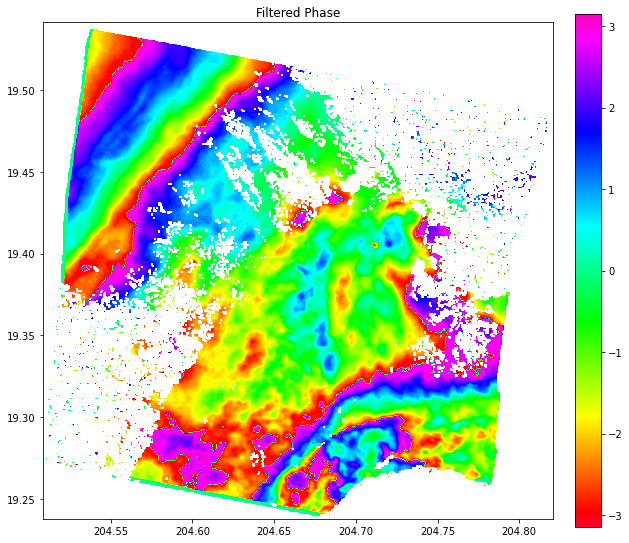

In [20]:
# None-Necessary Plotting part
# Check on the phasefilt in geo-coordinates
nc = NetCDFFile('intf/2011134_2011230/phasefilt_mask_ll.grd')
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='gist_rainbow',aspect=1,vmin = -3.15, vmax = 3.15)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)
plt.title("Filtered Phase")

Text(0.5, 1.0, 'Coherence')

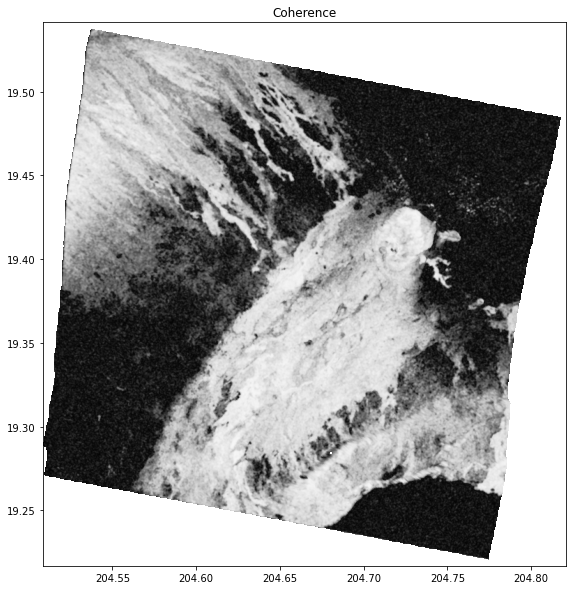

In [21]:
# None-Necessary Plotting part
# Check on the coherence in geo-coordinates
nc = NetCDFFile('intf/2011134_2011230/corr_ll.grd')
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=1,vmin = 0, vmax = 1)
plt.rcParams["figure.figsize"] = [10,10]
plt.title("Coherence")

Text(0.5, 1.0, 'Amplitude')

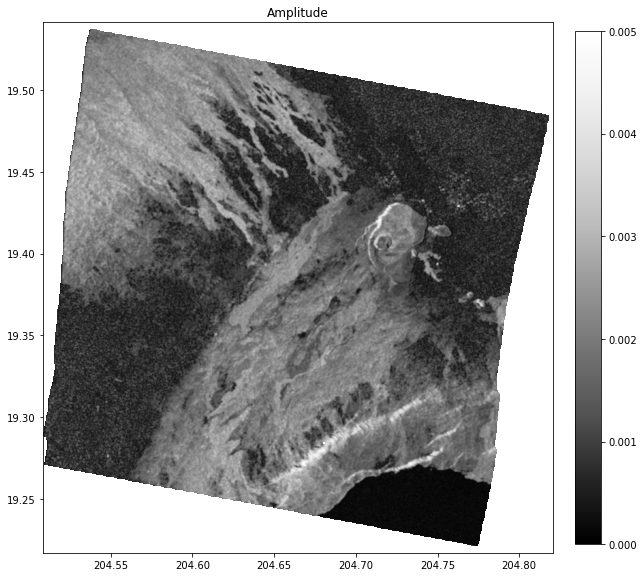

In [22]:
# None-Necessary Plotting part
# Check on the amplitude in geo-coordinates
nc = NetCDFFile('intf/2011134_2011230/display_amp_ll.grd')
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='Greys_r',aspect=1,vmin = 0, vmax = 0.005)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)
plt.title("Amplitude")

Text(0.5, 1.0, 'Line-Of-Sight Deformation (mm)')

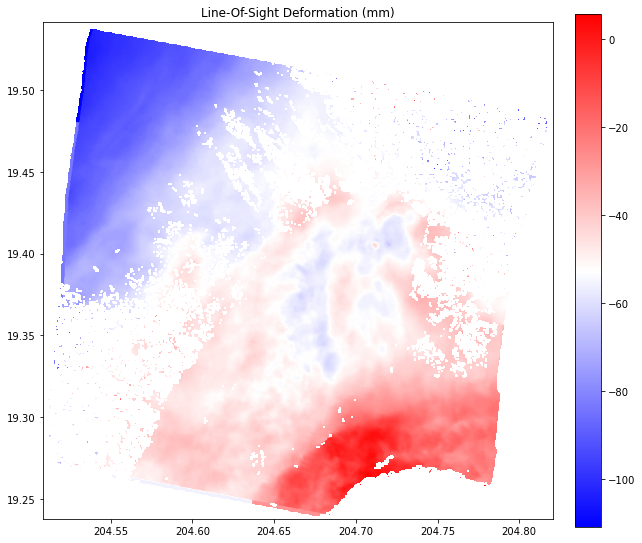

In [23]:
# None-Necessary Plotting part
# Check on the Line-Of-Sight singal in geo-coordinates
nc = NetCDFFile('intf/2011134_2011230/los_ll.grd')
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='bwr',aspect=1,vmin = np.min(z), vmax = np.max(z))
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)
plt.title("Line-Of-Sight Deformation (mm)")